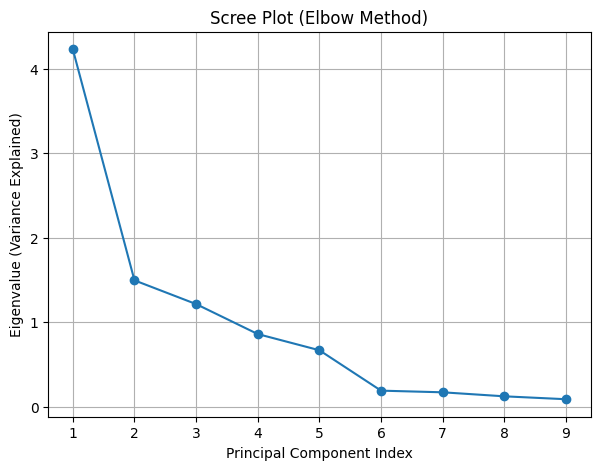

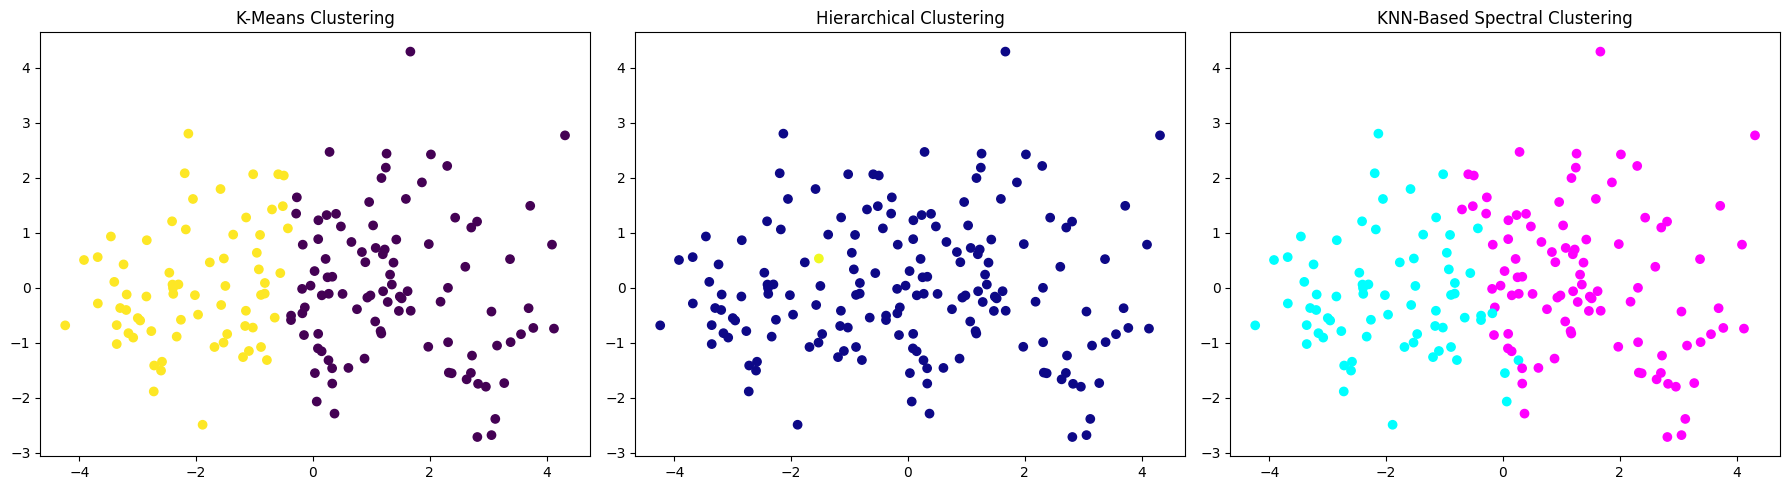


=== PERFORMANCE COMPARISON (SILHOUETTE SCORE) ===
K-Means:        0.2839
Hierarchical:   0.2880
KNN-Spectral:   0.5353


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================================
# 1. DATA PREPROCESSING 
# =========================================================

def preprocess_data(filename, corr_threshold=0.95, z_clip=3):
    df = pd.read_csv(filename)

    countries = df['country'].values
    X = df.drop('country', axis=1)

    # A. Missing values (mean imputation)
    for col in X.columns:
        X[col] = X[col].fillna(X[col].mean())

    X = X.values.astype(float)

    # B. Outlier clipping (Z-score)
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    z = (X - mean) / (std + 1e-8)
    X = np.where(np.abs(z) > z_clip, mean, X)

    # C. Remove low-variance features
    variances = np.var(X, axis=0)
    X = X[:, variances > 1e-4]

    # D. Remove highly correlated features
    corr = np.corrcoef(X.T)
    to_remove = set()
    for i in range(len(corr)):
        for j in range(i + 1, len(corr)):
            if abs(corr[i, j]) > corr_threshold:
                to_remove.add(j)

    if to_remove:
        keep = [i for i in range(X.shape[1]) if i not in to_remove]
        X = X[:, keep]

    # E. Standardization
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mean) / (std + 1e-8)

    return X, countries
print("Number of features kept:", X.shape[1])


# =========================================================
# 2. PCA (FOR VISUALIZATION)
# =========================================================

def pca_scratch(X, n_components=2):
    cov = np.cov(X.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]
    return X @ eigvecs[:, :n_components]
import numpy as np
import matplotlib.pyplot as plt

def scree_plot(X):
    # Covariance matrix
    cov = np.cov(X.T)

    # Eigen decomposition
    eigvals, _ = np.linalg.eigh(cov)

    # Sort eigenvalues in descending order
    eigvals = np.sort(eigvals)[::-1]

    # Plot
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, len(eigvals) + 1), eigvals, marker='o')
    plt.xlabel("Principal Component Index")
    plt.ylabel("Eigenvalue (Variance Explained)")
    plt.title("Scree Plot (Elbow Method)")
    plt.grid(True)
    plt.show()

    return eigvals


# =========================================================
# 3. DISTANCE FUNCTION
# =========================================================

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


# =========================================================
# 4. SILHOUETTE SCORE (SCRATCH)
# =========================================================

def silhouette_score_scratch(X, labels):
    scores = []

    for i in range(len(X)):
        same_cluster = X[labels == labels[i]]
        if len(same_cluster) <= 1:
            scores.append(0)
            continue

        a = np.mean([
            euclidean_distance(X[i], p)
            for p in same_cluster
            if not np.array_equal(p, X[i])
        ])

        b = min([
            np.mean([euclidean_distance(X[i], p) for p in X[labels == c]])
            for c in np.unique(labels) if c != labels[i]
        ])

        scores.append((b - a) / max(a, b))

    return np.mean(scores)


# =========================================================
# 5. K-MEANS CLUSTERING (IMPROVED – SCRATCH)
# =========================================================

class KMeansScratch:
    def __init__(self, k=2, max_iters=300, n_init=10):
        self.k = k
        self.max_iters = max_iters
        self.n_init = n_init

    def fit_predict(self, X):
        best_labels = None
        best_inertia = float('inf')

        for _ in range(self.n_init):
            centroids = X[np.random.choice(len(X), self.k, replace=False)]

            for _ in range(self.max_iters):
                distances = np.array([[euclidean_distance(x, c) for c in centroids] for x in X])
                labels = np.argmin(distances, axis=1)

                new_centroids = np.array([
                    X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
                    for i in range(self.k)
                ])

                if np.allclose(centroids, new_centroids):
                    break
                centroids = new_centroids

            inertia = np.sum([
                euclidean_distance(X[i], centroids[labels[i]]) ** 2
                for i in range(len(X))
            ])

            if inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels

        return best_labels


# =========================================================
# 6. HIERARCHICAL CLUSTERING (CENTROID LINKAGE – SCRATCH)
# =========================================================

class HierarchicalClusteringScratch:
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters

    def fit_predict(self, X):
        clusters = {i: [i] for i in range(len(X))}

        while len(clusters) > self.n_clusters:
            centroids = {k: X[v].mean(axis=0) for k, v in clusters.items()}
            keys = list(centroids.keys())

            min_dist, pair = float('inf'), None
            for i in range(len(keys)):
                for j in range(i + 1, len(keys)):
                    d = euclidean_distance(centroids[keys[i]], centroids[keys[j]])
                    if d < min_dist:
                        min_dist, pair = d, (keys[i], keys[j])

            clusters[pair[0]].extend(clusters[pair[1]])
            del clusters[pair[1]]

        labels = np.zeros(len(X), dtype=int)
        for idx, pts in enumerate(clusters.values()):
            labels[pts] = idx

        return labels


# =========================================================
# 7. KNN-BASED SPECTRAL CLUSTERING (CORRECT VERSION)
# =========================================================

class KNNSpectralClusteringScratch:
    def __init__(self, n_clusters=2, k_neighbors=15, sigma=1.0):
        self.n_clusters = n_clusters
        self.k_neighbors = k_neighbors
        self.sigma = sigma

    def fit_predict(self, X):
        n = len(X)
        W = np.zeros((n, n))

        # RBF-based KNN graph
        for i in range(n):
            dists = [(euclidean_distance(X[i], X[j]), j) for j in range(n)]
            dists.sort()
            for d, j in dists[1:self.k_neighbors + 1]:
                W[i, j] = W[j, i] = np.exp(-(d ** 2) / (2 * self.sigma ** 2))

        D = np.diag(W.sum(axis=1))
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D) + 1e-8))
        L = np.eye(n) - D_inv_sqrt @ W @ D_inv_sqrt

        eigvals, eigvecs = np.linalg.eigh(L)
        embedding = eigvecs[:, :self.n_clusters]

        # Row normalization
        embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)

        labels = KMeansScratch(self.n_clusters).fit_predict(embedding)
        return labels, embedding


# =========================================================
# 8. EXECUTION
# =========================================================

X, countries = preprocess_data(
    r"D:\OneDrive\Desktop\College\MrM Research\Coding\Data\data.csv"
)
eigvals = scree_plot(X)
X_pca = pca_scratch(X)

km_labels = KMeansScratch(2).fit_predict(X)
hc_labels = HierarchicalClusteringScratch(2).fit_predict(X)
knn_labels, knn_embed = KNNSpectralClusteringScratch(2, 15, 1.0).fit_predict(X)


# =========================================================
# 9. VISUALIZATION
# =========================================================

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=km_labels, cmap='viridis')
ax[0].set_title("K-Means Clustering")

ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hc_labels, cmap='plasma')
ax[1].set_title("Hierarchical Clustering")

ax[2].scatter(X_pca[:, 0], X_pca[:, 1], c=knn_labels, cmap='cool')
ax[2].set_title("KNN-Based Spectral Clustering")

plt.tight_layout()
plt.show()


# =========================================================
# 10. PERFORMANCE COMPARISON
# =========================================================

print("\n=== PERFORMANCE COMPARISON (SILHOUETTE SCORE) ===")
print(f"K-Means:        {silhouette_score_scratch(X, km_labels):.4f}")
print(f"Hierarchical:   {silhouette_score_scratch(X, hc_labels):.4f}")
print(f"KNN-Spectral:   {silhouette_score_scratch(knn_embed, knn_labels):.4f}")
